In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(111)

Prepare training data

In [3]:
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)
train_data[:, 1] = torch.sin(train_data[:, 0])
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

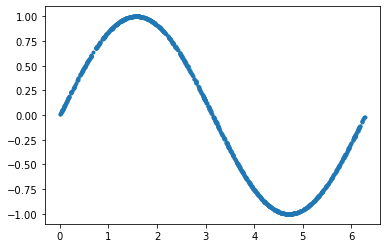

In [4]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")

In [5]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

Define Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        output = self.model(x)
        return output

In [7]:
discriminator = Discriminator()

In [8]:
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


Define Generator

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )
    def forward(self, x):
        output = self.model(x)
        return output
generator = Generator()

In [10]:
print(generator)

Generator(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)


Set model parameters

In [11]:
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()

In [12]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [13]:
fixed_latent_space_samples = torch.randn(100, 2)
train_plot=[]

Train Discriminator and Generator

In [14]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )
        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()
        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))
        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()
        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")
    generated_samples_plot = generator(fixed_latent_space_samples)
    generated_samples_plot = generated_samples_plot.detach()
    train_plot.append([epoch, generated_samples_plot[:, 0], generated_samples_plot[:, 1]])    

Epoch: 0 Loss D.: 0.191440150141716
Epoch: 0 Loss G.: 2.151118278503418
Epoch: 10 Loss D.: 0.6632499694824219
Epoch: 10 Loss G.: 0.785311222076416
Epoch: 20 Loss D.: 0.5742862224578857
Epoch: 20 Loss G.: 0.9071698784828186
Epoch: 30 Loss D.: 0.6343445777893066
Epoch: 30 Loss G.: 0.6459650993347168
Epoch: 40 Loss D.: 0.7113553285598755
Epoch: 40 Loss G.: 0.6791542768478394
Epoch: 50 Loss D.: 0.6962903738021851
Epoch: 50 Loss G.: 0.6613914370536804
Epoch: 60 Loss D.: 0.6727420091629028
Epoch: 60 Loss G.: 0.7479550242424011
Epoch: 70 Loss D.: 0.6929656863212585
Epoch: 70 Loss G.: 0.8366349339485168
Epoch: 80 Loss D.: 0.658658504486084
Epoch: 80 Loss G.: 0.7702726721763611
Epoch: 90 Loss D.: 0.6751717329025269
Epoch: 90 Loss G.: 1.3339283466339111
Epoch: 100 Loss D.: 0.6251543760299683
Epoch: 100 Loss G.: 0.9118934869766235
Epoch: 110 Loss D.: 0.6046939492225647
Epoch: 110 Loss G.: 0.7452861666679382
Epoch: 120 Loss D.: 0.6394419074058533
Epoch: 120 Loss G.: 0.9865816831588745
Epoch: 130 L

latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

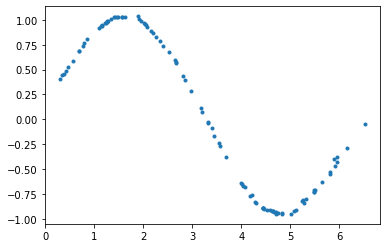

In [15]:
plt.plot(train_plot[299][1], train_plot[299][2], ".")

In [16]:
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython import display
import matplotlib.pyplot as plt

Figure = plt.figure()
 
# creating a plot
lines_plotted = plt.plot([],".")    
 
# putting limits on x axis since
# it is a trigonometry function
# (0,2∏)
line_plotted = lines_plotted[0]
 
plt.xlim(0,2*np.pi) 
 
# putting limits on y since it is a
# cosine function
plt.ylim(-1.1,1.1)
plt.title("Epoch - 0" )
 
# initialising x from 0 to 2∏
x = np.linspace(0,2*np.pi,100)   
 
#initially
y = 0

# function takes frame as an input
def AnimationFunction(frame):
 
    # setting y according to frame
    # number and + x. It's logic
    x= train_plot[frame][1]
    y = train_plot[frame][2]
    # displaying the title
    plt.title("Epoch - " + str(frame))
    # line is set with new values of x and y
    line_plotted.set_data((x, y))

anim_created = FuncAnimation(Figure, AnimationFunction, frames=300, interval=200)

video = anim_created.to_html5_video()
html = display.HTML(video)
display.display(html)
 
# good practice to close the plt object.
plt.close()